#### Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_parquet("/Users/tevfikerkut/Downloads/dataset_300_items.parquet")
df.DateKey = pd.to_datetime(df.DateKey, format= "%Y%m%d")
df = df.sort_values("DateKey").reset_index(drop = True)
df.head()

In [384]:
df.isna().sum()

DateKey                                   0
StoreCount                                0
ShelfCapacity                          2497
PromoShelfCapacity                        0
UnitPromotionThreshold               126336
IsPromo                                   0
national_holiday_new_years_day            0
national_holiday_good_friday              0
national_holiday_easter_sunday            0
national_holiday_easter_monday            0
national_holiday_kings_day                0
national_holiday_rememberance_day         0
national_holiday_liberation_day           0
national_holiday_ascension                0
national_holiday_white_sunday             0
national_holiday_white_monday             0
national_holiday_christmas                0
national_holiday_boxing_day               0
SchoolHolidayMiddle                   94808
SchoolHolidayNorth                    94808
SchoolHolidaySouth                    94808
TempMin                                   0
TempMax                         

Wow! We have lots of null values in our dataset. I am dropping Base Price, Communication Channel, Alcohol Percentage, Minage and Unit Promotion Threshold. Other's can be filled by 0. For instance NAN in Discount Percentage would probably means %0 discount.

In [385]:
df = df.drop(columns = ["BasePrice", "CommunicationChannel", "AlcoholPercentage", "MinAge",
                   "UnitPromotionThreshold"])

In [386]:
df.fillna(0, inplace = True)

Now, I am expanding the dataframe with more useful columns

In [387]:
# Expand dataframe with more useful columns
df.DateKey = pd.to_datetime(df.DateKey)
def expand_df(df):
    data = df.copy()
    data['day'] = data.DateKey.dt.day
    data['month'] = data.DateKey.dt.month
    data['year'] = data.DateKey.dt.year
    data['dayofweek'] = data.DateKey.dt.dayofweek
    data['week'] = data.DateKey.dt.week
    return data

df = expand_df(df)
display(df)


,DateKey,StoreCount,ShelfCapacity,PromoShelfCapacity,IsPromo,national_holiday_new_years_day,national_holiday_good_friday,national_holiday_easter_sunday,national_holiday_easter_monday,national_holiday_kings_day,...,ItemNumber,CategoryCode,GroupCode,UnitSales,DiscountPercentage,day,month,year,dayofweek,week
0,2016-01-04,187,11712.0,0,False,0,0,0,0,0,...,9021,7289,5524,610.0,0.00,4,1,2016,0,1
1,2016-01-04,827,7145.0,0,False,0,0,0,0,0,...,8997,7291,5526,4389.0,0.00,4,1,2016,0,1
2,2016-01-04,832,8884.0,0,False,0,0,0,0,0,...,8071,7292,5577,358.0,0.00,4,1,2016,0,1
3,2016-01-04,78,1412.0,0,False,0,0,0,0,0,...,11316,7292,5492,217.0,0.00,4,1,2016,0,1
4,2016-01-04,3,21.0,0,False,0,0,0,0,0,...,9246,7292,5612,53.0,0.00,4,1,2016,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136804,2017-12-31,678,8663.0,0,True,0,0,0,0,0,...,9873,7291,5550,1808.0,0.26,31,12,2017,6,52
136805,2017-12-31,412,7902.0,0,False,0,0,0,0,0,...,10623,7289,5604,241.0,0.00,31,12,2017,6,52
136806,2017-12-31,535,5163.0,0,False,0,0,0,0,0,...,10243,7292,5556,216.0,0.00,31,12,2017,6,52
136807,2017-12-31,546,6894.0,0,True,0,0,0,0,0,...,10842,7292,5541,75.0,0.25,31,12,2017,6,52


### Data Preprocessing & Feature Engineering

Firstly, I will create my target feature >  The sum of weekly sales. Next:

- The average of dayofweek_sales : (Friday average, Thursday average etc..) (days take values from 0 to 6 )

- Weekly Sales Average : Average of sales done per week. ( weeks take values from 0 to 51)

- Weekly Store Count : The sum of store count per week


- Weekly Shelf Capacity : The sum of shelf capacity per week

- Weekly Promo Shelf Capacity : The sum of promo shelf capacity per week

In [388]:
df["weekly_sales_sum"] = df.groupby(["week", "year"], as_index= False)["UnitSales"].transform("sum")
df["dayofweek_sales_avg"] = df.groupby("dayofweek")["UnitSales"].transform("mean")
df["weekly_sales_avg"] = df.groupby("week")["UnitSales"].transform("mean")
df["weekly_store_count"] = df.groupby(["week", "year"], as_index= False)["StoreCount"].transform("sum")
df["weekly_shelfcapacity"] = df.groupby(["week", "year"], as_index= False)["ShelfCapacity"].transform("sum")
df["weekly_promoshelfcapacity"] = df.groupby(["week", "year"], as_index= False)["PromoShelfCapacity"].transform("sum")

Let's replace False with 0 and True with 1 in IsPromo


In [391]:
df.IsPromo = df.IsPromo.replace({False: 0, True: 1})

Since our dataframe is based on daily transactions ( multiple rows per day ), I want to convert it into a weekly dataframe. Therefore I have to apply some transformations to other columns, just like I did with " weekly sales sum "

Now, at the code cell right below, I converted my holiday&promotion features into a weekly form. So basically, ispromo feature will now tell me how many is promo days have been existed in that week.

In [392]:
for i in ['IsPromo', 'national_holiday_new_years_day',
       'national_holiday_good_friday', 'national_holiday_easter_sunday',
       'national_holiday_easter_monday', 'national_holiday_kings_day',
       'national_holiday_rememberance_day', 'national_holiday_liberation_day',
       'national_holiday_ascension', 'national_holiday_white_sunday',
       'national_holiday_white_monday', 'national_holiday_christmas',
       'national_holiday_boxing_day', 'SchoolHolidayMiddle',
       'SchoolHolidayNorth', 'SchoolHolidaySouth']:
    df[i] = df.groupby(["day", "week", "month", "year"], as_index= False)[i].transform("max")
    name = i + "_count_in_week"
    df[name] = df.groupby(["week", "year"])[i].transform("sum")

For numerical columns, I will take their weekly means. And for categorical columns, I will take their weekly mode.

In [393]:
df[['TempMin', 'TempMax',
       'TempAvg', 'RainFallSum', 'SundurationSum', 'ItemNumber',
       'CategoryCode', 'GroupCode', 'UnitSales', 'DiscountPercentage']]

,TempMin,TempMax,TempAvg,RainFallSum,SundurationSum,ItemNumber,CategoryCode,GroupCode,UnitSales,DiscountPercentage
0,3.572222,4.527778,4.002315,0.0,1.733333,9021,7289,5524,610.0,0.00
1,3.572222,4.527778,4.002315,0.0,1.733333,8997,7291,5526,4389.0,0.00
2,3.572222,4.527778,4.002315,0.0,1.733333,8071,7292,5577,358.0,0.00
3,3.572222,4.527778,4.002315,0.0,1.733333,11316,7292,5492,217.0,0.00
4,3.572222,4.527778,4.002315,0.0,1.733333,9246,7292,5612,53.0,0.00
...,...,...,...,...,...,...,...,...,...,...
136804,8.427778,12.466667,10.330324,0.0,1.355556,9873,7291,5550,1808.0,0.26
136805,8.427778,12.466667,10.330324,0.0,1.355556,10623,7289,5604,241.0,0.00
136806,8.427778,12.466667,10.330324,0.0,1.355556,10243,7292,5556,216.0,0.00
136807,8.427778,12.466667,10.330324,0.0,1.355556,10842,7292,5541,75.0,0.25


In [394]:
for i in ['TempMin', 'TempMax',
       'TempAvg', 'RainFallSum', 'SundurationSum', "DiscountPercentage"]:
    name = i + "weekly_avg"
    df[name] = df.groupby(["week", "year"], as_index= False)[i].transform("mean")

In [395]:
for i in ['ItemNumber',
       'CategoryCode', 'GroupCode']:
    name = i + "weekly_mode"
    df[name] = df.groupby(["week", "year"], as_index= False)[i].transform("median")

We are ready to go with our weekly features!!!

In [397]:
df = df[['year', 'month', 'week', 'dayofweek', 'weekly_sales_sum',
       'dayofweek_sales_avg', 'weekly_sales_avg', 'weekly_store_count',
       'weekly_shelfcapacity', 'weekly_promoshelfcapacity',
       'IsPromo_count_in_week', 'national_holiday_new_years_day_count_in_week',
       'national_holiday_good_friday_count_in_week',
       'national_holiday_easter_sunday_count_in_week',
       'national_holiday_easter_monday_count_in_week',
       'national_holiday_kings_day_count_in_week',
       'national_holiday_rememberance_day_count_in_week',
       'national_holiday_liberation_day_count_in_week',
       'national_holiday_ascension_count_in_week',
       'national_holiday_white_sunday_count_in_week',
       'national_holiday_white_monday_count_in_week',
       'national_holiday_christmas_count_in_week',
       'national_holiday_boxing_day_count_in_week',
       'SchoolHolidayMiddle_count_in_week', 'SchoolHolidayNorth_count_in_week',
       'SchoolHolidaySouth_count_in_week', 'TempMinweekly_avg',
       'TempMaxweekly_avg', 'TempAvgweekly_avg', 'RainFallSumweekly_avg',
       'SundurationSumweekly_avg', 'DiscountPercentageweekly_avg',
       'ItemNumberweekly_mode', 'CategoryCodeweekly_mode',
       'GroupCodeweekly_mode']]
data = df.drop_duplicates(["week", "year", "month"])
data = data.reset_index(drop = True)

#### Let's take a look at the distribution of sales

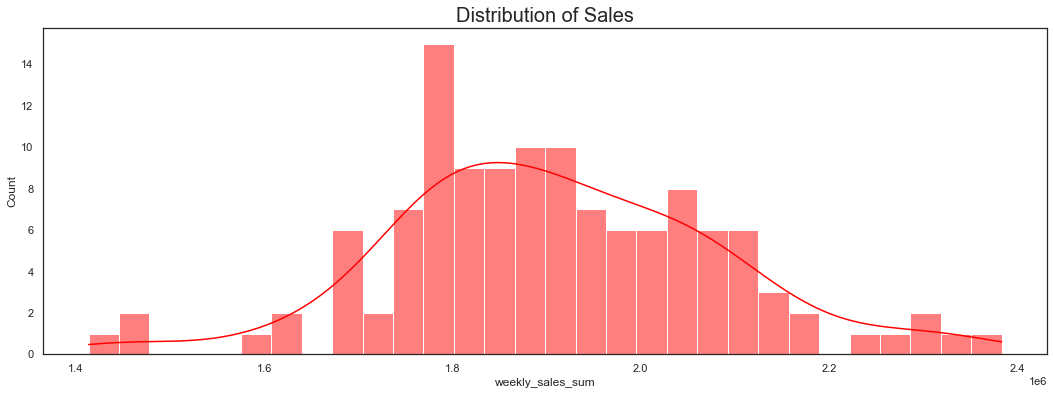

In [398]:
sns.set(rc={'figure.figsize':(18,6)})
sns.set_style("white")
sns.histplot(data.weekly_sales_sum, kde = True, bins = 30, color = "red").set_title("Distribution of Sales", fontsize =20);

Let's take our categorical variables

In [403]:
data.CategoryCodeweekly_mode.value_counts() # I am dropping this column, since it just contains one unique value

7291.0    124
Name: CategoryCodeweekly_mode, dtype: int64

In [404]:
data.drop(columns = "CategoryCodeweekly_mode", inplace = True)

##### Group Code pie chart

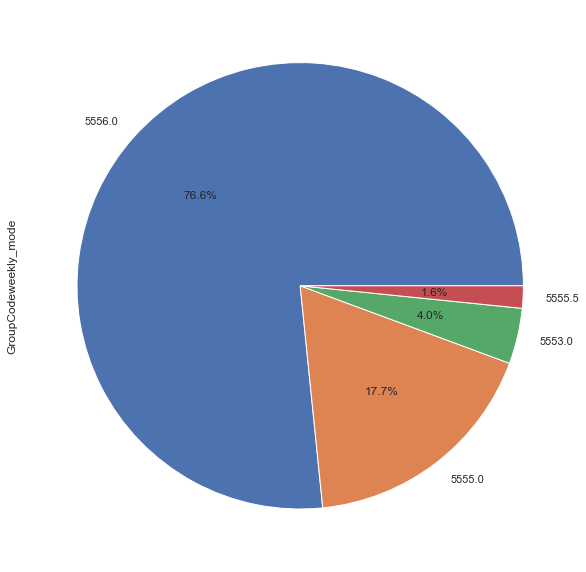

In [405]:
plt.figure(figsize=(10,15))
data['GroupCodeweekly_mode'].value_counts().plot.pie(autopct = "%1.1f%%")
plt.show()

##### Let's compare years by sales

In [418]:
yearly_sale = df.groupby('year')['weekly_sales_sum']
yearly_sale.sum().astype(int)

year
2016    119862014378
2017    142265733166
Name: weekly_sales_sum, dtype: int64

<Figure size 864x576 with 0 Axes>

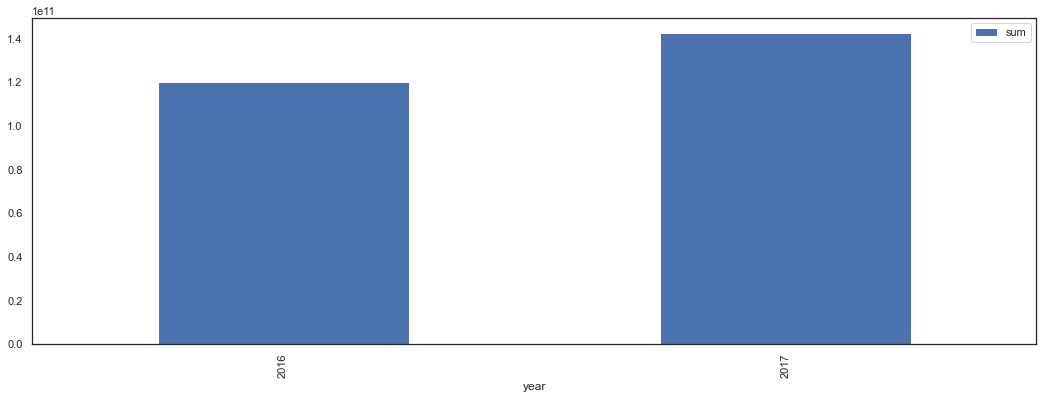

In [419]:
plt.figure(figsize=(12, 8))
yearly_sale.agg(['sum']).plot.bar()
plt.show()

##### Visualization of sale numbers in the past ( index values are weeks. 120th week, 60th week, etc.)

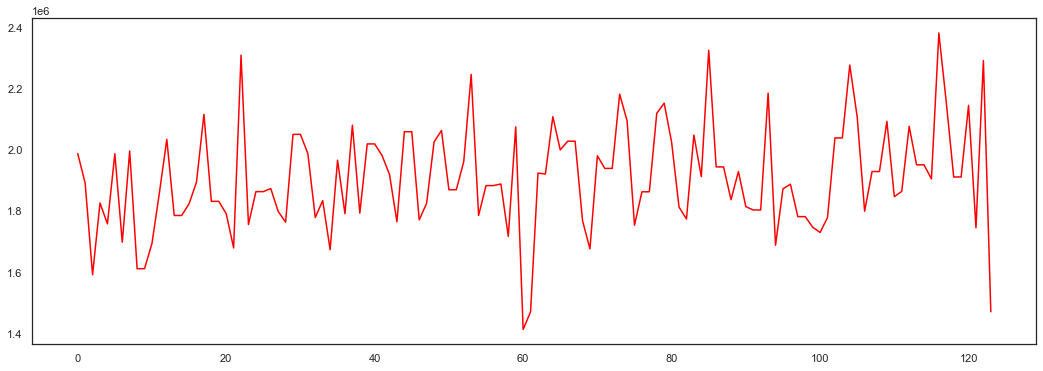

In [426]:
plt.plot(data.weekly_sales_sum, color = "red")

Let's create some other useful features! 

It's quite clear that lag features play huge role in forecasting problems, thats why I will try few lag tricks in here!

In [427]:
data["weekly_shelfcapacity_shifted1"] = data["weekly_shelfcapacity"].shift(1)
data["GroupCodeweekly_mode_shifted1"] = data["GroupCodeweekly_mode"].shift(1)

In [428]:
data["weekly_store_count_shifted2"] = data["weekly_store_count"].shift(2)
data["weekly_store_count_shifted3"] = data["weekly_store_count"].shift(3)
data["weekly_store_count_shifted4"] = data["weekly_store_count"].shift(4)

Okay, we are ready to go! Let's forecast 5 months!

In [432]:
train = data[:105]
test = data[105:]

X_train = train.drop(["weekly_sales_sum"],1)
y_train = train.weekly_sales_sum

X_test = test.drop(["weekly_sales_sum"],1)
y_test = test.weekly_sales_sum

#### LightGBM

In [434]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
lgbm_model = lgbm.LGBMRegressor(objective = "regression")
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

In [435]:
lgbm_result = smape(y_test, preds)

In [436]:
print("LightGBM model has SMAPE score of {}".format(lgbm_result))

LightGBM model has SMAPE score of 7.111866538614904


#### XGBoost

In [437]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
preds_xgb = xgb_model.predict(X_test)

In [438]:
xgb_result = smape(y_test, preds_xgb)
print("XGBoost model has SMAPE score of {}".format(xgb_result))

XGBoost model has SMAPE score of 6.246886302790237


#### CatBoost

In [439]:
import catboost as cat

cat_model = cat.CatBoostRegressor()
cat_model.fit(X_train, y_train)
preds_cat = cat_model.predict(X_test)

Learning rate set to 0.028677
0:	learn: 163707.8304848	total: 4.65ms	remaining: 4.64s
1:	learn: 162117.5763099	total: 6.67ms	remaining: 3.33s
2:	learn: 160615.3592848	total: 8.67ms	remaining: 2.88s
3:	learn: 159586.4588085	total: 10.3ms	remaining: 2.56s
4:	learn: 158382.1630703	total: 11.9ms	remaining: 2.37s
5:	learn: 156912.0638621	total: 15.7ms	remaining: 2.61s
6:	learn: 155416.5018906	total: 19.9ms	remaining: 2.83s
7:	learn: 154600.9009883	total: 22.6ms	remaining: 2.8s
8:	learn: 153056.6990019	total: 23.6ms	remaining: 2.59s
9:	learn: 151931.9949649	total: 24.5ms	remaining: 2.42s
10:	learn: 150589.3115071	total: 25.4ms	remaining: 2.28s
11:	learn: 149668.8871679	total: 29.7ms	remaining: 2.45s
12:	learn: 148642.7326310	total: 33.9ms	remaining: 2.58s
13:	learn: 147394.6496022	total: 35.3ms	remaining: 2.49s
14:	learn: 146633.7190478	total: 36.7ms	remaining: 2.41s
15:	learn: 145316.6489346	total: 37.5ms	remaining: 2.31s
16:	learn: 144089.8040995	total: 38.7ms	remaining: 2.24s
17:	learn: 1

In [445]:
cat_result = smape(y_test, preds_cat)
cat_result
print("CatBoost model has SMAPE score of {}".format(cat_result))

CatBoost model has SMAPE score of 5.401646754093084


#### Let's try some time series algorithms

In [441]:
X = data["weekly_sales_sum"].values
df_forecast = data["weekly_sales_sum"].to_frame()
train, test = df_forecast[0:105], df_forecast[105:len(X)]

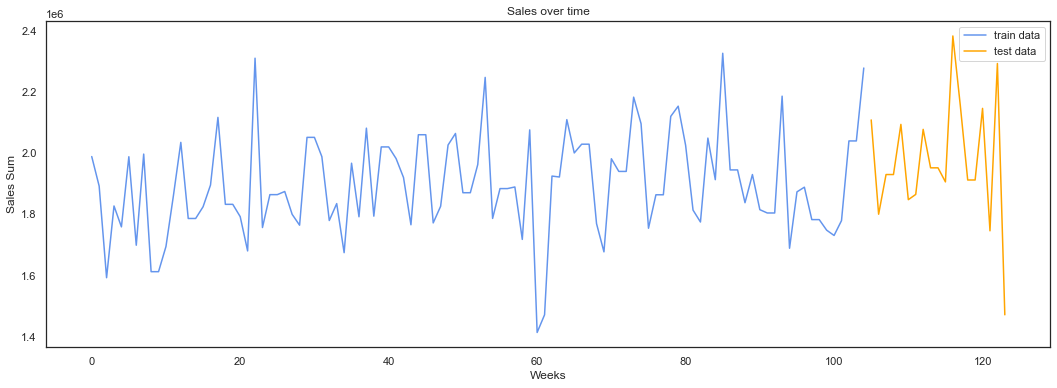

In [442]:

train_set_dates = train.index  # for plotting
test_set_dates = test.index 

plt.plot(train, color='cornflowerblue', label='train data')
plt.plot(test, color='orange', label='test data')
plt.legend(loc='best')
plt.title(f'Sales over time')
plt.xlabel('Weeks')
plt.ylabel('Sales Sum')
plt.show()

### Let's start with AR ( Auto Regression )

In [444]:
from statsmodels.tsa.ar_model import AutoReg
lags = range(8,54,2)
p_params = []

SMAPE = []

for lag in lags:

    try:
        model = AutoReg(train, lags=lag)  # use time span of 1 year for lagging
        trained_model = model.fit()
        predictions = trained_model.predict(start=len(train), 
                                    end=len(train) + len(test) - 1)

        error_smape = smape(test.weekly_sales_sum, predictions)
        SMAPE.append(error_smape)
        p_params.append(lag)
    except:
        continue
    
for i,j in zip(p_params, SMAPE):
    print("For p of {} , SMAPE is {}".format(i,j))


For p of 8 , SMAPE is 8.160928526429029
For p of 10 , SMAPE is 8.056274250698527
For p of 12 , SMAPE is 8.20101704071157
For p of 14 , SMAPE is 8.179227924852386
For p of 16 , SMAPE is 8.508082517950793
For p of 18 , SMAPE is 8.949334977828475
For p of 20 , SMAPE is 9.11427379541577
For p of 22 , SMAPE is 8.85830389994392
For p of 24 , SMAPE is 8.641974699084866
For p of 26 , SMAPE is 9.05322808314385
For p of 28 , SMAPE is 9.019033323095885
For p of 30 , SMAPE is 9.313416679272892
For p of 32 , SMAPE is 9.436936786839478
For p of 34 , SMAPE is 9.24499692355789
For p of 36 , SMAPE is 9.350100536451722
For p of 38 , SMAPE is 9.182556793169127
For p of 40 , SMAPE is 9.968386238708964
For p of 42 , SMAPE is 10.418196955250952
For p of 44 , SMAPE is 10.391089480933896
For p of 46 , SMAPE is 12.76925198650763
For p of 48 , SMAPE is 17.571171104378877
For p of 50 , SMAPE is 80.96927594755724


Best model is with p == 10

In [446]:

AR_model = AutoReg(train, lags=10)  # use time span of 1 year for lagging
trained_model = AR_model.fit()
predictions = trained_model.predict(start=len(train), 
                                    end=len(train) + len(test) - 1).astype(int)
AR_error_smape = smape(test.weekly_sales_sum, predictions)
print("AR model has SMAPE score of {}".format(AR_error_smape))



AR model has SMAPE score of 8.056279558026091


#### Let's try MA ( Moving Average )

In [448]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [450]:
q_list = range(1,15)
q_params = []

SMAPE = []

for q in q_list:

    try:
        MA_model = ARIMA(endog=train, order=(0, 0, q))
        MA_model = MA_model.fit()

        predictions = MA_model.predict(start=test.index[0], 
                                    end=test.index[-1])

        error_SMAPE = smape(test.weekly_sales_sum, predictions)
        SMAPE.append(error_SMAPE)
        q_params.append(q)
    except:
        continue
    
for i,j in zip(q_params, SMAPE):
    print("For q of {} , SMAPE is {}".format(i,j))


For q of 1 , SMAPE is 7.8488264055675145
For q of 2 , SMAPE is 7.873231104213375
For q of 3 , SMAPE is 8.02410183950753
For q of 4 , SMAPE is 8.036159001920751
For q of 5 , SMAPE is 8.00119129739389
For q of 6 , SMAPE is 8.010017669952285
For q of 7 , SMAPE is 8.176020906875648
For q of 8 , SMAPE is 8.310492600298113
For q of 9 , SMAPE is 8.335829101808294
For q of 10 , SMAPE is 8.371256375280662
For q of 11 , SMAPE is 8.298061182890867
For q of 12 , SMAPE is 8.428558940653424
For q of 13 , SMAPE is 8.352418263662155
For q of 14 , SMAPE is 8.603276877727279


Best MA model is with q = 1

In [457]:
MA_model = ARIMA(endog=train, order=(0, 0, 1))
MA_model = MA_model.fit()

predictions = MA_model.predict(start=test.index[0], 
                            end=test.index[-1])

MA_error_SMAPE = smape(test.weekly_sales_sum, predictions)
print("MA model has SMAPE score of {}".format(MA_error_SMAPE))

MA model has SMAPE score of 7.8488264055675145


### ARMA

In [455]:
q_list = [1,2,3,4,5,6]
p_list = [1,2,3,4]

SMAPE = []
p_q_params = []

for q in q_list:
    for p in p_list:

        try:
            ARMA_model = ARIMA(endog=train, order=(p, 0, q))
            ARMA_model = ARMA_model.fit()

            predictions = ARMA_model.predict(start=test.index[0], 
                                        end=test.index[-1])

            error_SMAPE = smape(test.weekly_sales_sum, predictions)
            SMAPE.append(error_SMAPE)
            p_q_params.append([p,q])
        except:
            continue
for i,j in zip(p_q_params, SMAPE):
    print("For p of {}, q of {} , SMAPE is {}".format(i[0], i[1], j))

For p of 1, q of 1 , SMAPE is 7.848565885579575
For p of 2, q of 1 , SMAPE is 7.925410497965415
For p of 3, q of 1 , SMAPE is 8.103539657606728
For p of 4, q of 1 , SMAPE is 8.10458076519253
For p of 1, q of 2 , SMAPE is 7.945342769725529
For p of 2, q of 2 , SMAPE is 8.300165115842873
For p of 3, q of 2 , SMAPE is 8.102689794585222
For p of 4, q of 2 , SMAPE is 8.277664184608902
For p of 1, q of 3 , SMAPE is 8.038156139204203
For p of 2, q of 3 , SMAPE is 8.023374808672042
For p of 3, q of 3 , SMAPE is 8.302526318346652
For p of 4, q of 3 , SMAPE is 8.2805976843986
For p of 1, q of 4 , SMAPE is 8.028501210244197
For p of 2, q of 4 , SMAPE is 7.991972861077382
For p of 3, q of 4 , SMAPE is 8.044980321223797
For p of 4, q of 4 , SMAPE is 8.378626614713564
For p of 1, q of 5 , SMAPE is 7.982769584827598
For p of 2, q of 5 , SMAPE is 8.114473480853512
For p of 3, q of 5 , SMAPE is 8.03699871442156
For p of 4, q of 5 , SMAPE is 8.36729921218097
For p of 1, q of 6 , SMAPE is 8.0997859784059

Best Arima model is with p = 1, q = 1

In [456]:
ARMA_model = ARIMA(endog=train, order=(p, 0, q))
ARMA_model = ARMA_model.fit()

predictions = ARMA_model.predict(start=test.index[0], 
                            end=test.index[-1])

ARMA_result = smape(test.weekly_sales_sum, predictions)
print("ARMA model has SMAPE score of {}".format(ARMA_result))

ARMA model has SMAPE score of 8.083771753983664


### Let's compare the results

In [465]:
comparison_df  =pd.DataFrame([lgbm_result , xgb_result, cat_result, AR_error_smape, MA_error_SMAPE, ARMA_result], columns = ["SMAPE Score"])
comparison_df.index = ["LightGBM", "XGBoost", "CatBoost", "AR", "MA", "ARMA"]
comparison_df = comparison_df.T

In [466]:
comparison_df

,LightGBM,XGBoost,CatBoost,AR,MA,ARMA
SMAPE Score,7.111867,6.246886,5.401647,8.05628,7.848826,8.083772


Our best prediction comes from CatBoost model! let's visualize it!

In [467]:
import matplotlib.pyplot as plt
import seaborn as sns

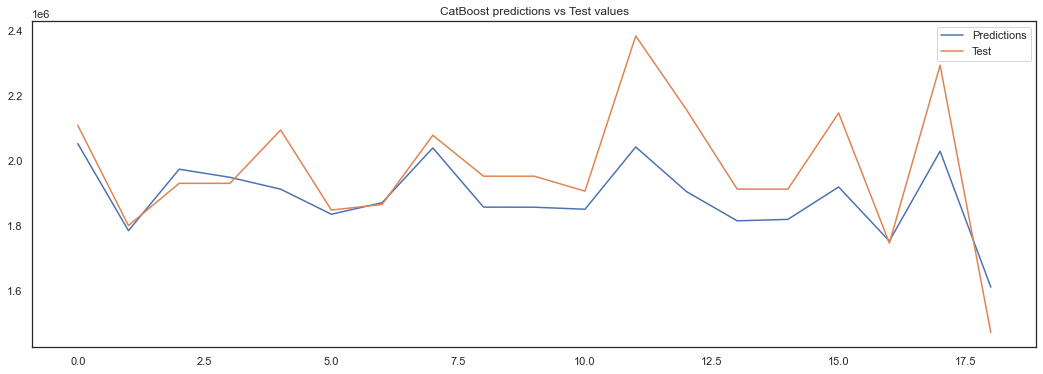

In [470]:
test_values = pd.DataFrame(y_test).reset_index(drop = True)
test_values["predictions"] = preds_cat
plt.plot(test_values.predictions, label = "Predictions")
plt.plot(test_values.weekly_sales_sum, label = "Test")
plt.title("CatBoost predictions vs Test values")
plt.legend()


### LONG LIVE CATBOOST!